# Inferring with Informative Priors 

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [42]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.stats
import mut.bayes
import mut.viz
pboc = mut.viz.color_selector('pboc')
mut.viz.plotting_style()
constants = mut.thermo.load_constants()
prior_bounds = mut.thermo.global_fit_params()

In this notebook, we revisit the inference of the DNA binding energy, this time using informative priors for the various model parameters deteremindd for the wild-type LacI repressor in Razo-Mejia et al. 2018. These parameters, as reported, are the mode and bounds of the 95% credible region of the parameter estimates. As it is difficult to directly map the credible region as priors, we approximate them as normal distributions centered at the mode with the standard deviation as the average of the upper and lower bound of the creidble region.

In [13]:
# Load the data and assign the prior information 
data = pd.read_csv('../../data/csv/compiled_data.csv')
for g, d in data.groupby(['repressors', 'operator']):
    r_key = f'R{int(g[0])}'
    data.loc[data['repressors']==g[0], 'rep_mu'] = prior_bounds[r_key + '_mu'] 
    data.loc[data['repressors']==g[0], 'rep_sig'] = prior_bounds[r_key + '_sig'] 
    data.loc[data['operator']==g[1], 'epRA_mu'] = prior_bounds[g[1] + '_mu']
    data.loc[data['operator']==g[1], 'epRA_sig'] = prior_bounds[g[1] + '_mu']

# Inferring DNA binding energy

In [16]:
# Load the stan model
model = mut.bayes.StanModel('../stan/DNA_binding_energy_informative_priors.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a9cbfc29225389fa118049fc161a1998 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmppl42f4ox/stanfit4anon_model_a9cbfc29225389fa118049fc161a1998_4971257695459243982.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


To see if this approach is feasible, we will begin by choosing a single DNA binding mutant and repressor copy number.  

In [59]:
DNA_data = data[(data['class']=='DNA') & (data['operator']=='O2')] 
fit_data = DNA_data[(DNA_data['mutant']=='Y20I') & (DNA_data['repressors']==260)]

In [60]:
# Assemble the data dictionary and sample. 
data_dict = {'N':len(fit_data),
            'R_mu':fit_data['rep_mu'].unique()[0],
            'R_sig':fit_data['rep_sig'].unique()[0],
            'Nns':constants['Nns'],
            'ep_ai':constants['ep_AI'],
            'n_sites':constants['n_sites'],
            'Ka_mu':prior_bounds['Ka_mu'],
            'Ka_sig':prior_bounds['Ka_sig'],
            'Ki_mu': prior_bounds['Ki_mu'],
            'Ki_sig':prior_bounds['Ki_sig'],
            'c':fit_data['IPTGuM'],
            'fc':fit_data['fold_change']}
fit, samples = model.sample(data_dict)

# Compute the summary data
summary = mut.stats.compute_statistics(samples[['Ka', 'Ki', 'R', 'ep_RA', 'sigma', 'lp__']], logprob_name='lp__')

The sampling proceeded without a hitch (no divergences, well-mixed chains, and good effective sample sizes). We can now see how well this fit captures the data.  

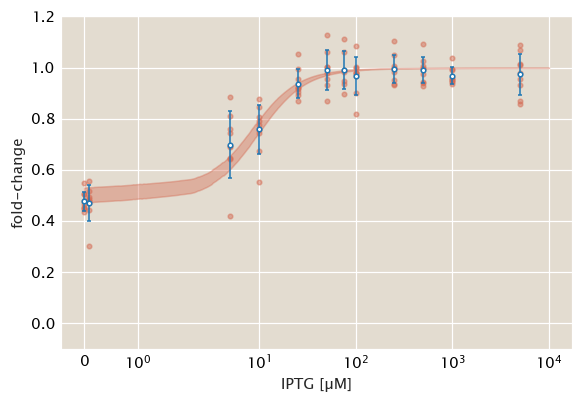

In [61]:
# Compute the credible region given the sampling statistics. 
c_range = np.logspace(-3, 4, 500)
c_range[0] = 0
cred_region = np.zeros((2, len(c_range)))
for i, c in enumerate(c_range):
    theo= mut.thermo.SimpleRepression(R=samples['R'], ep_r=samples['ep_RA'],
                                      ka=samples['Ka'], ki=samples['Ki'],
                                      ep_ai=constants['ep_AI'], 
                                      n_sites=constants['n_sites'],
                                      effector_conc=c).fold_change()
    cred_region[:, i] = mut.stats.compute_hpd(theo, 0.95)
    
    
# Set up the figure 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=110)
ax.set_xscale('symlog')
ax.set_xlabel("IPTG [µM]")
ax.set_ylabel("fold-change")
ax.set_ylim([-0.1, 1.2])

# Plot all of the data
ax.plot(fit_data['IPTGuM'], fit_data['fold_change'], '.', color=pboc['red'],
        alpha=0.5)

# Plot the summarized data. 
summarized = fit_data.groupby(['IPTGuM']).agg(('mean', 'std')).reset_index()
ax.errorbar(summarized['IPTGuM'], summarized['fold_change']['mean'], 
            summarized['fold_change']['std'], fmt='.', markerfacecolor='w',
           lw=1, linestyle='none', capsize=1, zorder=1000)

# Plot the credible region. 
ax.fill_between(c_range, cred_region[0, :], cred_region[1, :], 
                color=pboc['red'], alpha=0.4)


That looks like a pretty reasonable fit. Let's now try using the parameter estimates *only* from the  